In [1]:
!pip install networkx[default,extra]


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from langchain.prompts import PromptTemplate
import json
import pandas as pd

In [3]:
MODEL_NAME = "TheBloke/Mistral-7B-OpenOrca-GPTQ"

In [4]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    device_map="auto"
)

Using `disable_exllama` is deprecated and will be removed in version 4.37. Use `use_exllama` instead and specify the version with `exllama_config`.The value of `use_exllama` will be overwritten by `disable_exllama` passed in `GPTQConfig` or stored in your config file.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
SYS_PROMPT = (
    "You are a network graph maker who extracts terms and their relations from a given context. "
    "You are provided with a context chunk (delimited by ```) Your task is to extract the ontology "
    "of terms mentioned in the given context. These terms should represent the key concepts as per the context. \n"
    "Thought 1: While traversing through each sentence, Think about the key terms mentioned in it.\n"
        "\tTerms may include object, entity, location, organization, person, \n"
        "\tcondition, acronym, documents, service, concept, etc.\n"
        "\tTerms should be as atomistic as possible\n\n"
    "Thought 2: Think about how these terms can have one on one relation with other terms.\n"
        "\tTerms that are mentioned in the same sentence or the same paragraph are typically related to each other.\n"
        "\tTerms can be related to many other terms\n\n"
    "Thought 3: Find out the relation between each such related pair of terms. \n\n"
    "Format your output as a list of json. Each element of the list contains a pair of terms"
    "and the relation between them, like the follwing: \n"
    "[\n"
    "   {\n"
    '       "node_1": "A concept from extracted ontology",\n'
    '       "node_2": "A related concept from extracted ontology",\n'
    '       "edge": "relationship between the two concepts, node_1 and node_2, in a sentence or less"\n'
    "   }, {...}\n"
    "]"
)

USER_PROMPT = "context: ```{context}``` \n\n output: "

In [6]:
generation_config = {
            "min_new_tokens":1,
            "max_new_tokens":1000,
            "do_sample":False,
            # "temperature":temperature,
            # "repetition_penalty":repetition_penalty,
            # "num_beams":num_beams,
            # "num_return_sequences":num_return_sequences,
        }

In [7]:
test_text = """Mary had a little lamb,
You’ve heard this tale before;
But did you know she passed her plate,
And had a little more!"""

In [8]:
user_prompt_formatted = USER_PROMPT.format(context=test_text)

In [9]:
prompt = f"{SYS_PROMPT}\n\n{user_prompt_formatted}"

In [10]:
prompt

'You are a network graph maker who extracts terms and their relations from a given context. You are provided with a context chunk (delimited by ```) Your task is to extract the ontology of terms mentioned in the given context. These terms should represent the key concepts as per the context. \nThought 1: While traversing through each sentence, Think about the key terms mentioned in it.\n\tTerms may include object, entity, location, organization, person, \n\tcondition, acronym, documents, service, concept, etc.\n\tTerms should be as atomistic as possible\n\nThought 2: Think about how these terms can have one on one relation with other terms.\n\tTerms that are mentioned in the same sentence or the same paragraph are typically related to each other.\n\tTerms can be related to many other terms\n\nThought 3: Find out the relation between each such related pair of terms. \n\nFormat your output as a list of json. Each element of the list contains a pair of termsand the relation between them, 

In [11]:
input_tensor = tokenizer.encode(prompt, return_tensors="pt").to("cuda")

In [12]:
output_tensor = model.generate(input_tensor, **generation_config)

/usr/local/lib/python3.10/site-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


In [13]:
generated_tensor = output_tensor[:, input_tensor.shape[1] :]

In [14]:
generated_text = tokenizer.batch_decode(generated_tensor)[0]

In [15]:
model_stop_token = "<|im_end|>"
generated_text = generated_text.split(model_stop_token)[0]

In [16]:
generated_text

'\n[\n   {\n       "node_1": "Mary",\n       "node_2": "lamb",\n       "edge": "had a little lamb"\n   }, {\n       "node_1": "Mary",\n       "node_2": "plate",\n       "edge": "passed her plate"\n   }, {\n       "node_1": "Mary",\n       "node_2": "more",\n       "edge": "had a little more"\n   }\n]'

In [17]:
relationships_json = json.loads(generated_text)

In [18]:
df = pd.DataFrame(relationships_json)

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

In [20]:
nodes = [n for n in df["node_1"]]
nodes.extend([n for n in df["node_2"]])
nodes = list(set(nodes))

In [21]:
nodes

['Mary', 'more', 'lamb', 'plate']

In [22]:
G = nx.Graph()

## Add nodes to the graph
for node in nodes:
    G.add_node(str(node))

## Add edges to the graph
edges = {}
for index, row in df.iterrows():
    node_1 = row["node_1"]
    node_2 = row["node_2"]
    title = row["edge"]
    G.add_edge(
        node_1,
        node_2,
        title=title
    )
    edges[(node_1, node_2)] = title

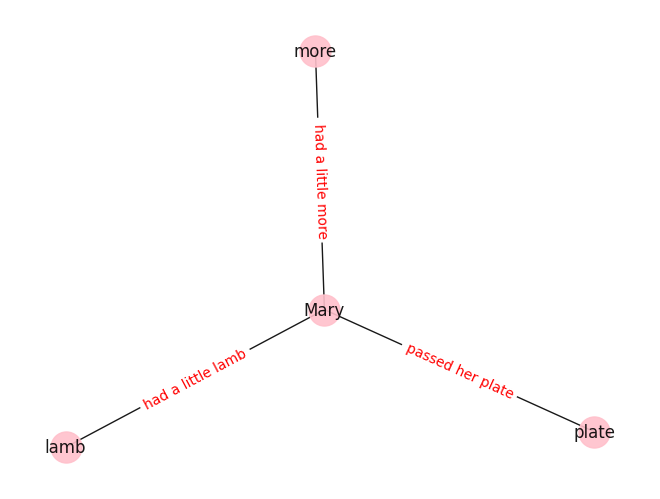

In [23]:
plt.figure()
pos = nx.spring_layout(G)
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edges,
    font_color='red'
)
plt.axis('off')
plt.show()